### Empirical Model
How can we apply an empirical model to increase the performance of the model?


### Antoine Equation
$$
ln(P^{*}) = A-\frac{B}{T+C}
$$

We need to remove the column in the dataset, which contains the Vapor Pressure measurements

In [160]:
import pandas as pd
import torch
import numpy as np

data = pd.read_csv('distillation-tower.csv')

X = data.drop('VapourPressure', axis=1)
X = X.iloc[:, 1:]
y = data['VapourPressure']

Now, we need to develop our empirical model by regressing ln(P) vs 1/T.

In [161]:
invt = data['InvTemp3']
vp = data['VapourPressure']

In [162]:
vp = np.log(vp)

In [163]:
from sklearn.linear_model import LinearRegression

invt = np.array(invt).reshape(-1, 1)
vp = np.array(vp)

model = LinearRegression()

model.fit(invt, vp)

vp_pred = np.exp(model.predict(invt))
X['Antoine'] = vp_pred

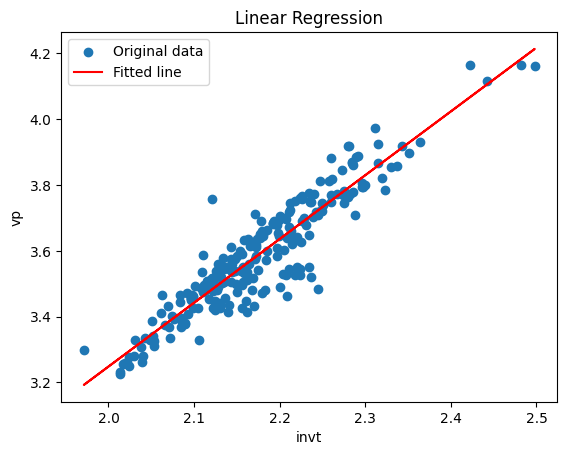

R-squared: 0.8649881279307753


In [164]:
import matplotlib.pyplot as plt

plt.scatter(invt, vp, label='Original data')

# Plotting the regression line
plt.plot(invt, np.log(vp_pred), color='red', label='Fitted line')

plt.xlabel('invt')
plt.ylabel('vp')
plt.title('Linear Regression')
plt.legend()

plt.show()

# If you want to evaluate the model you can use metrics like R-squared
r_squared = model.score(invt, vp)
print(f'R-squared: {r_squared}')

Important to note that the data we are working with has small variations due to the scale. This is because we are taking the natural log of vapor pressure. Thus, the r squared value with be naturally small. It is important to note the change in scales as we compare models.

From our graph, we can see that the regression model is pretty good at fitting the data.
Now we can use the model to predict the vapor pressure and use this in our neural network.
The goal is for the neural network to use our pressure as a starting point.

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train data for delta model
train_ln = np.log(y_train)
train_vp = np.array(train_ln)
invt_train = np.array(X_train['InvTemp3']).reshape(-1, 1)
model = LinearRegression()
model.fit(invt_train, train_vp)
vp_delta = np.exp(model.predict(invt_train))
y_train_delta = y_train - vp_delta

# Test data for delta model
test_vp = np.array(np.log(y_test))
invt_test = np.array(X_test['InvTemp3']).reshape(-1, 1)
model.fit(invt_test, test_vp)
test_prediction = np.exp(model.predict(invt_test))
y_test_delta = y_test - test_prediction

In [148]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

y_train_delta_tensor = torch.tensor(y_train_delta.values, dtype=torch.float32)
y_test_delta_tensor = torch.tensor(y_test_delta.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_delta_dataset = TensorDataset(X_train_tensor, y_train_delta_tensor)
test_delta_dataset = TensorDataset(X_test_tensor, y_test_delta_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_delta_dataloader = DataLoader(train_delta_dataset, batch_size=32, shuffle=True)
test_delta_dataloader = DataLoader(test_delta_dataset, batch_size=32, shuffle=False)

In [149]:
import torch.nn as nn

class VaporPressureNet(nn.Module):
    def __init__(self):
        super(VaporPressureNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [150]:
nn2 = VaporPressureNet()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(nn2.parameters(), lr=0.001)

epochs = 3000

for epoch in range(epochs):
    nn2.train() 
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = nn2(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

nn2.eval() 
with torch.no_grad(): 
    predictions = []
    targets = []
    for inputs, true_values in test_dataloader:
        outputs = nn2(inputs)
        predictions.extend(outputs.squeeze().tolist())
        targets.extend(true_values.tolist())

from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(targets, predictions)
mae = mean_absolute_error(targets, predictions)
print(f'R^2 Score on test set: {r2:.4f}')
print(f'Mean absolute error on test set: {mae: .4f}')

Epoch 1/3000, Loss: 1552.8114
Epoch 2/3000, Loss: 412.4791
Epoch 3/3000, Loss: 114.4996
Epoch 4/3000, Loss: 142.5631
Epoch 5/3000, Loss: 68.0574
Epoch 6/3000, Loss: 90.7100
Epoch 7/3000, Loss: 73.2022
Epoch 8/3000, Loss: 73.2839
Epoch 9/3000, Loss: 69.1642
Epoch 10/3000, Loss: 67.6219
Epoch 11/3000, Loss: 66.0317
Epoch 12/3000, Loss: 65.9515
Epoch 13/3000, Loss: 66.0799
Epoch 14/3000, Loss: 63.6882
Epoch 15/3000, Loss: 63.4225
Epoch 16/3000, Loss: 62.6756
Epoch 17/3000, Loss: 62.1459
Epoch 18/3000, Loss: 61.6299
Epoch 19/3000, Loss: 60.9279
Epoch 20/3000, Loss: 60.4593
Epoch 21/3000, Loss: 60.3903
Epoch 22/3000, Loss: 60.5395
Epoch 23/3000, Loss: 58.8222
Epoch 24/3000, Loss: 57.8653
Epoch 25/3000, Loss: 57.5816
Epoch 26/3000, Loss: 56.6652
Epoch 27/3000, Loss: 56.3326
Epoch 28/3000, Loss: 57.0689
Epoch 29/3000, Loss: 56.4097
Epoch 30/3000, Loss: 58.1386
Epoch 31/3000, Loss: 60.0922
Epoch 32/3000, Loss: 55.9350
Epoch 33/3000, Loss: 58.9457
Epoch 34/3000, Loss: 58.2535
Epoch 35/3000, Los

In [151]:
def evaluate_fi(n):
    single_observation = X_test.iloc[n]
    single_observation = single_observation.apply(pd.to_numeric, errors='coerce').fillna(0)
    single_observation_tensor = torch.tensor(single_observation.values, dtype=torch.float32).unsqueeze(0)
    nn2.eval()
    with torch.no_grad():
        prediction = nn2(single_observation_tensor) 
    # lnp = vp_pred[80]
    print("Predicted Vapour Pressure:", prediction.item())
    print("Experimental Vapour pressure:", y_test.iloc[n])
    # print("Antoine Model Prediction:", np.exp(lnp))

In [157]:
evaluate_fi(20)

Predicted Vapour Pressure: 52.422218322753906
Experimental Vapour pressure: 51.011


In [153]:
nn3 = VaporPressureNet()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(nn3.parameters(), lr=0.001)

epochs = 3000

for epoch in range(epochs):
    nn3.train() 
    running_loss = 0.0
    for inputs, targets in train_delta_dataloader:
        optimizer.zero_grad()
        outputs = nn3(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_delta_dataloader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

nn3.eval() 
with torch.no_grad(): 
    predictions2 = []
    targets2 = []
    for inputs, true_values in test_delta_dataloader:
        outputs2 = nn3(inputs)
        predictions2.extend(outputs2.squeeze().tolist())
        targets2.extend(true_values.tolist())

from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(targets2, predictions2)
mae = mean_absolute_error(targets2, predictions2)
print(f'R^2 Score on test set: {r2:.4f}')
print(f'Mean absolute error on test set: {mae:.4f}')

Epoch 1/3000, Loss: 230.2575
Epoch 2/3000, Loss: 63.5632
Epoch 3/3000, Loss: 40.0993
Epoch 4/3000, Loss: 20.3495
Epoch 5/3000, Loss: 11.6731
Epoch 6/3000, Loss: 8.3072
Epoch 7/3000, Loss: 7.7318
Epoch 8/3000, Loss: 6.1826
Epoch 9/3000, Loss: 5.8603
Epoch 10/3000, Loss: 5.8597
Epoch 11/3000, Loss: 6.3741
Epoch 12/3000, Loss: 6.7513
Epoch 13/3000, Loss: 6.4380
Epoch 14/3000, Loss: 5.4550
Epoch 15/3000, Loss: 5.5019
Epoch 16/3000, Loss: 6.3124
Epoch 17/3000, Loss: 5.9573
Epoch 18/3000, Loss: 5.4784
Epoch 19/3000, Loss: 4.9653
Epoch 20/3000, Loss: 5.1505
Epoch 21/3000, Loss: 5.0720
Epoch 22/3000, Loss: 5.1144
Epoch 23/3000, Loss: 5.1580
Epoch 24/3000, Loss: 5.4914
Epoch 25/3000, Loss: 5.3830
Epoch 26/3000, Loss: 4.9469
Epoch 27/3000, Loss: 4.9492
Epoch 28/3000, Loss: 5.0625
Epoch 29/3000, Loss: 4.9515
Epoch 30/3000, Loss: 5.1422
Epoch 31/3000, Loss: 4.6454
Epoch 32/3000, Loss: 4.6318
Epoch 33/3000, Loss: 4.6668
Epoch 34/3000, Loss: 4.5783
Epoch 35/3000, Loss: 5.4588
Epoch 36/3000, Loss: 4.

In [154]:
def evaluate(n):
    single_observation = X_test.iloc[n]
    single_observation = single_observation.apply(pd.to_numeric, errors='coerce').fillna(0)
    single_observation_tensor = torch.tensor(single_observation.values, dtype=torch.float32).unsqueeze(0)
    nn3.eval()
    with torch.no_grad():
        prediction = nn3(single_observation_tensor)     
    vapor = test_prediction[n]
    y = prediction.item() + vapor
    print("Predicted Vapour Pressure:", y)
    print("Experimental Vapour pressure:", y_test.iloc[n])


In [165]:
evaluate(26)
evaluate_fi(26)

Predicted Vapour Pressure: 35.48731931537828
Experimental Vapour pressure: 36.5717
Predicted Vapour Pressure: 37.15103530883789
Experimental Vapour pressure: 36.5717
